# Bonus tasks

 - The `ResidualBlock` module performs two 3x3 convolutions. In the ResNet paper, an alternative block, the bottleneck block is discussed. In this, the two 3x3 convolutions are replaced with a sequence of one 1x1 convolution, one 3x3 convolution and then a final 1x3 convolution. Here, the first 1x1 convolution reduces the number of channels of the input tensor so that the 3x3 convolution is computationally less expensive. The final 1x1 convolution then restores the previous dimension. Implement this in a `BottleneckBlock` class. You can pass the block module that should be used to the `CIFAR10ResNet20` via the `block` argument.
 - In the residual blocks, one can also use "pre-activations" (see [this paper](https://arxiv.org/pdf/1603.05027.pdf)). This means, that BatchNorm and ReLU are performed before the convolutions instead of after them. This further increases the network performance. Adjust the block implementation accordingly.
 - In this notebook, we only calculate the accuracy, which means that the class for which the network calculated the highest probability has to match the label. A common metric on datasets with a higher number of classes is Top-K-Accuracy. For this, the correct class has to occur in the K classes that the network predicted the highest probabilities for. Implement a Top-3-Accuracy metric and draw the graph for it.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
from torchvision.datasets import CIFAR10

train_data = CIFAR10('./cifar', download=True, train=True)
val_data = CIFAR10('./cifar', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from torchvision.transforms import ToTensor, Compose, Normalize, RandomHorizontalFlip, RandomCrop
from torch.utils.data import DataLoader

# Image transforms
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
normalize = Normalize(mean=normalize_mean, std=normalize_std)

train_transform = Compose([
    RandomHorizontalFlip(),
    RandomCrop(32, 4),
    ToTensor(),
    normalize
])
val_transform = Compose([
    ToTensor(),
    normalize
])

train_data_torch = CIFAR10('./cifar', download=True, train=True, transform=train_transform)
val_data_torch = CIFAR10('./cifar', download=True, train=False, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
BATCH_SIZE = 128
train_loader = DataLoader(train_data_torch, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data_torch, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [5]:
import torch.nn as nn

class BottleneckBlock(nn.Module):
    
    def __init__(self, channels_in, K, stride=1):
        super(BottleneckBlock, self).__init__()
        
        self.residual_function = nn.Sequential(
            nn.BatchNorm2d(channels_in),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels_in, K, kernel_size=1, bias=False),
            nn.BatchNorm2d(K),
            nn.ReLU(inplace=True),
            nn.Conv2d(K, K * 4, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(K * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(K * 4, K, kernel_size=1, bias=False),
        )
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()

        if stride != 1 or channels_in != K:
            self.shortcut = nn.Sequential(
                nn.BatchNorm2d(channels_in),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels_in, K, stride=stride, kernel_size=1, bias=False),
            )

    def forward(self, x):
        out = self.residual_function(x)
        shortcut = self.shortcut(x)
        out += shortcut
        out = self.relu(out)
        return out


class ResidualLayer(nn.Module):
    def __init__(self, K_in, K, num_blocks, stride=1, block=BottleneckBlock):
        super(ResidualLayer, self).__init__()

        modules = [block(K_in, K, stride=stride)]

        for j in range(num_blocks - 1):
            modules.append(block(K, K))  

        self.model = nn.Sequential(*modules)

    def forward(self, x):
        x = self.model(x)
        return x


class CIFAR10ResNet20(nn.Module):
    def __init__(self, num_classes, block=BottleneckBlock):
        super(CIFAR10ResNet20, self).__init__()
        # number of blocks per layer
        self.layers = [3, 3, 3]
        # filter sizes / channels per layer
        self.filters = [16, 32, 64]
        # stride of the first block in each layer
        self.strides = [1, 2, 2]

        # The number of filters for the first conv layer
        C0 = 16
        modules = []
        conv1 = nn.Conv2d(3, C0, (3, 3), padding=1, stride=1, bias=False)

        modules += [
            conv1,
            nn.BatchNorm2d(C0),
            nn.ReLU()
        ]

        # instantiate all the layers
        for i in range(len(self.layers)):
            in_channels = C0 if i == 0 else self.filters[i-1]
            modules.append(ResidualLayer(
                in_channels, self.filters[i], self.layers[i], stride=self.strides[i], block=block))

        # adaptive max pooling reduces the remaining image to a 1x1 image with the previous
        # number of channels (self.filters[-1])
        modules.append(nn.AdaptiveAvgPool2d((1, 1)))

        # our model is a simple sequential flow of the previously defined modules
        # (skip connections were already handled in the ResidualBlocks)
        self.model = nn.Sequential(*modules)
        # Classification layer
        self.linear = nn.Linear(self.filters[-1], num_classes)
        # note that there is no softmax layer here because cross_entropy loss in pytorch
        # already includes the softmax operation.

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.model(x)

        # flatten the tensor to a 1D array (but with batch_size still intact)
        x = x.view(x.size(0), -1)

        x = self.linear(x)
        return x


In [6]:
model = CIFAR10ResNet20(num_classes=10)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
LR = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=0.0001, momentum=0.9)

In [7]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
train_top3_accuracy = []  
val_top3_accuracy = [] 

In [8]:
#Task-3
def top_k_accuracy(output, target, k=3):
    with torch.no_grad():
        pred = torch.topk(output, k, dim=1)[1]
        correct = pred.eq(target.view(-1, 1).expand_as(pred))
        correct_k = correct.view(-1).float().sum(0, keepdim=True)
        return correct_k.mul_(100.0 / output.size(0))

In [9]:
from torch.nn.functional import cross_entropy
import numpy as np
import tqdm

NUM_EPOCHS = 20
NUM_CLASSES = 10

train_batch_epoch_limit = 100
val_batch_epoch_limit = 100


correct_top3_predictions = 0
total_samples = 0


for epoch in range(NUM_EPOCHS):
    # perform training followed by validation
    for mode, loader, batch_epoch_limit in [
        ("train", train_loader, train_batch_epoch_limit),
        ("val", val_loader, val_batch_epoch_limit)
    ]:
        # progressbar setup
        num_batches = min(len(loader), batch_epoch_limit)
        pbar = tqdm.tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train() # do calculate gradients for training mode
        else:
            model.eval() # do not calculate gradients in validation mode

        # initial values of the metrics (loss, accurracy)
        runningLoss = 0.
        correct_predictions = 0

        # loop over the data
        for i_batch, batch in zip(range(num_batches), loader):
            images, labels = batch
            # move tensors to the correct device
            images = images.to(device)
            labels = labels.to(device)

            # run the model
            predictions = model.forward(images)

            # loss calculation
            loss = cross_entropy(predictions, labels)

            # calculate the metrics for the progress bar
            num_batch_samples = len(images)
            runningLoss += loss.item() * num_batch_samples
            correct_predictions += (torch.argmax(predictions, dim=-1) == labels).sum().item()
            correct_top3_predictions += top_k_accuracy(predictions, labels, k=3).item() * num_batch_samples
            total_samples += num_batch_samples

            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples,
                "accuracy": correct_predictions / total_samples,
                "top-3 accuracy": correct_top3_predictions / total_samples
            })

            # weight update
            if mode == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epoch_loss = runningLoss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        epoch_top3_accuracy = correct_top3_predictions / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_accuracy)
            train_top3_accuracy.append(epoch_top3_accuracy)
        else:
            val_losses.append(epoch_loss)
            val_accuracy.append(epoch_accuracy)
            val_top3_accuracy.append(epoch_top3_accuracy)
                    
        pbar.close()


train epoch 0: 100%|█| 100/100 [01:40<00:00,  1.01s/it, loss=2.16, accuracy=0.19
val epoch 0: 100%|█| 79/79 [00:34<00:00,  2.30it/s, loss=0.852, accuracy=0.117, 
train epoch 1: 100%|█| 100/100 [01:38<00:00,  1.01it/s, loss=0.672, accuracy=0.1
val epoch 1: 100%|█| 79/79 [00:33<00:00,  2.39it/s, loss=0.394, accuracy=0.0688,
train epoch 2: 100%|█| 100/100 [01:38<00:00,  1.01it/s, loss=0.381, accuracy=0.0
val epoch 2: 100%|█| 79/79 [00:33<00:00,  2.34it/s, loss=0.251, accuracy=0.0518,
train epoch 3: 100%|█| 100/100 [01:44<00:00,  1.05s/it, loss=0.261, accuracy=0.0
val epoch 3: 100%|█| 79/79 [00:34<00:00,  2.28it/s, loss=0.182, accuracy=0.0406,
train epoch 4: 100%|█| 100/100 [02:00<00:00,  1.21s/it, loss=0.196, accuracy=0.0
val epoch 4: 100%|█| 79/79 [00:46<00:00,  1.71it/s, loss=0.136, accuracy=0.0363,
train epoch 5: 100%|█| 100/100 [01:53<00:00,  1.13s/it, loss=0.154, accuracy=0.0
val epoch 5: 100%|█| 79/79 [00:32<00:00,  2.42it/s, loss=0.113, accuracy=0.0321,
train epoch 6: 100%|█| 100/1

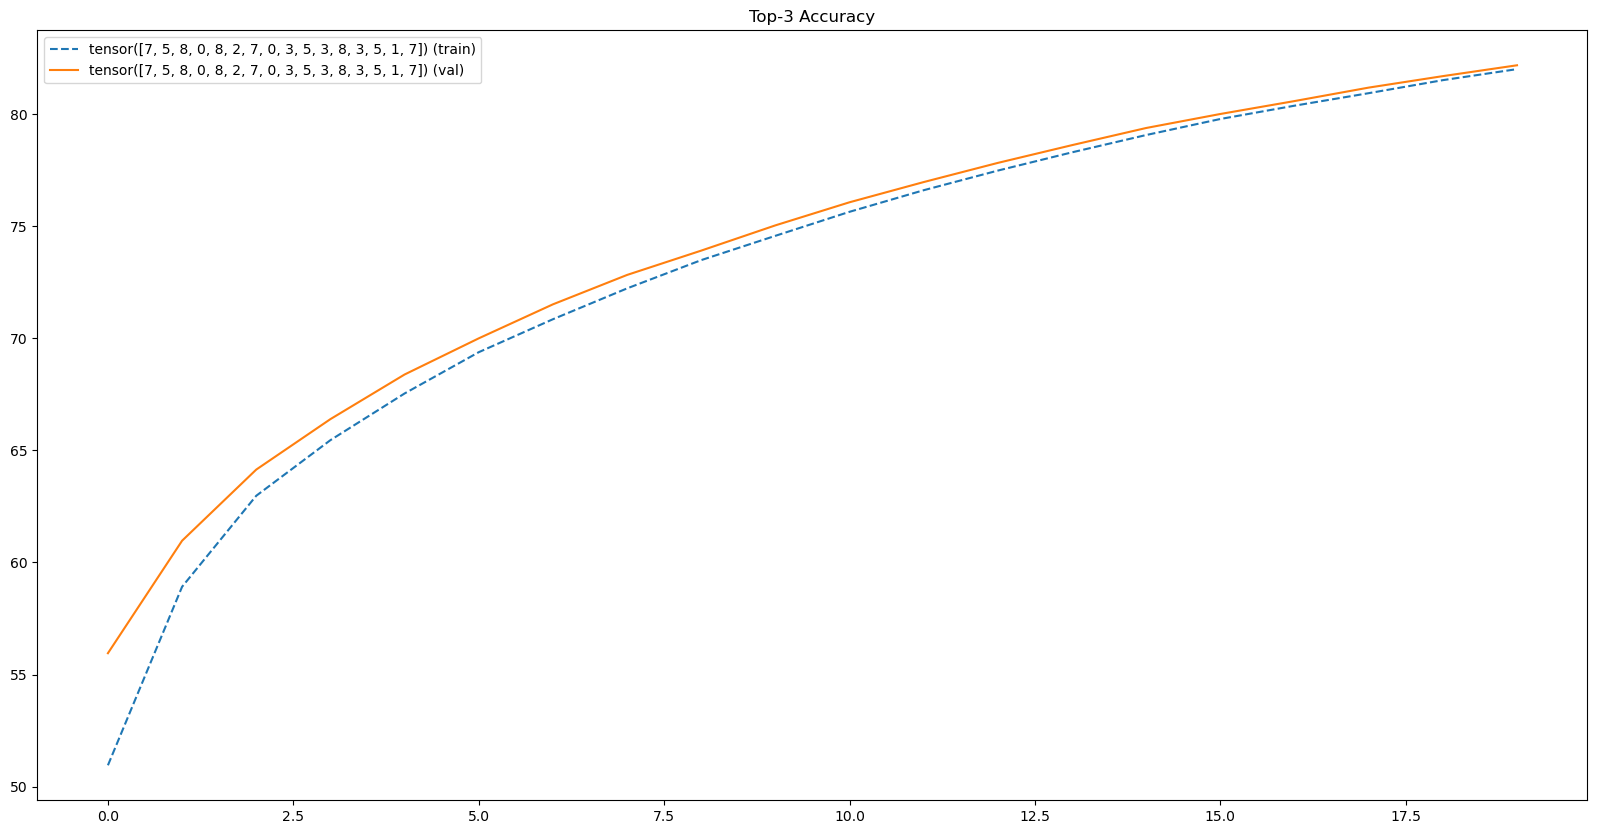

In [10]:
top3_acc = top_k_accuracy(predictions, labels, k=3)
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Top-3 Accuracy')
ax.plot(train_top3_accuracy, '--', label=f"{labels} (train)")
ax.plot(val_top3_accuracy, label=f"{labels} (val)")
ax.legend()
plt.show()